Epochs: 001/100 	Error Train: 0.8679555825628021 	Error Test: 0.873440496244854
Epochs: 011/100 	Error Train: 0.056888176580108994 	Error Test: 0.11786115220864739
Epochs: 021/100 	Error Train: 0.018502482820773145 	Error Test: 0.08400058060630124
Epochs: 031/100 	Error Train: 0.009610311220040474 	Error Test: 0.0759500507381724
Epochs: 041/100 	Error Train: 0.005989727071435497 	Error Test: 0.08028158579407811
Epochs: 051/100 	Error Train: 0.0042442259662062165 	Error Test: 0.07829471579790157
Epochs: 061/100 	Error Train: 0.0032459661992058713 	Error Test: 0.07648625780179262
Epochs: 071/100 	Error Train: 0.0026469610111045363 	Error Test: 0.07930669236714462
Epochs: 081/100 	Error Train: 0.0021744266256659137 	Error Test: 0.0778682674186014
Epochs: 091/100 	Error Train: 0.0018570694384320067 	Error Test: 0.07868230868581491


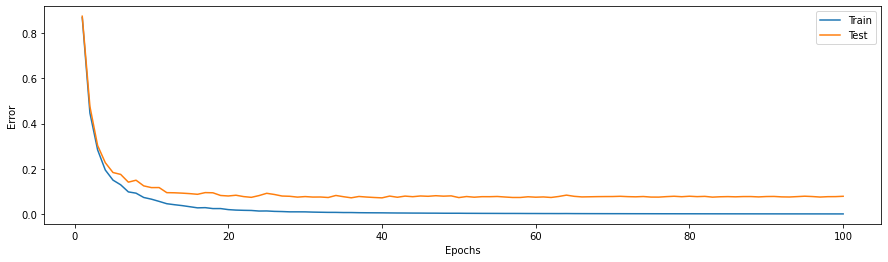


1.0 0.9866666666666667

1.6586101055145264


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

class NeuralNetwork:
    def __init__(self):
        self.img_size = 8
        self.n_mid = 64
        self.n_out = 10
        
        self.eta = 0.001
        self.epochs = 100
        self.batch_size = 32
        self.interval = 10
        
        self.digits_data = datasets.load_digits()
        
        # Train & Test Split
        self.data_lst = self.splitData(self.loadInputData(), self.loadCorrectData())
        self.x_train = self.data_lst[0]
        self.x_test = self.data_lst[1]
        self.t_train = self.data_lst[2]
        self.t_test = self.data_lst[3]

        self.layers = [
            MiddleLayer(self.img_size ** 2, self.n_mid),
            MiddleLayer(self.n_mid, self.n_mid),
            MiddleLayer(self.n_mid, self.n_mid),
            OutputLayer(self.n_mid, self.n_out)
        ]
        
        self.error_record_train = []
        self.error_record_test = []
        self.n_batch = len(self.x_train) // self.batch_size
        
        for i in range(self.epochs):
            index_random = np.arange(len(self.x_train))
            np.random.shuffle(index_random)
            
            for j in range(self.n_batch):
                mb_index = index_random[j * self.batch_size : (j+1) * self.batch_size]
                x_mb = self.x_train[mb_index, :]
                t_mb = self.t_train[mb_index, :]
                
                # 학습
                self.forward_propagation(x_mb)
                # 점검
                self.back_propagation(t_mb)
                # 업데이트
                self.update_params()
            
            error_train = self.get_error(self.x_train, self.t_train)
            self.error_record_train.append(error_train)
            error_test = self.get_error(self.x_test, self.t_test)
            self.error_record_test.append(error_test)
            
            if i%self.interval == 0:
                if i<10:
                    num = "00" + str(i+1)
                elif i < 100:
                    num = "0" + str(i+1)
                else:
                    num = str(i+1)
                print("Epochs: " + num + "/" + str(self.epochs), 
                      "\tError Train: " + str(error_train), 
                      "\tError Test: " + str(error_test)
                )
        
        plt.figure(figsize = (15, 4))
        plt.plot(range(1, len(self.error_record_train) + 1), self.error_record_train, label = "Train")
        plt.plot(range(1, len(self.error_record_test) + 1), self.error_record_test, label = "Test")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.show()
        
        acc_train = self.get_accuracy(self.x_train, self.t_train)
        acc_test = self.get_accuracy(self.x_test, self.t_test)
        
        print()
        print(acc_train, acc_test)
        print()
    
    def LoadModel(self):
        return self.layers
    
    def UseModel(self, x):
        # 여기다 데이터를 넣으면 결과값이 나옴
        # 이쪽으로 데이터를 넣으면 학습된 모델을 사용할 수 있음
        y = self.forward_propagation(x)
        arr = np.argmax(y, axis = 1)
        return arr
    
    def loadInputData(self):
        input_data = np.asarray(self.digits_data.data)
        # Mean: 0, standard derivation: 1
        input_data = (input_data - np.average(input_data)) / np.std(input_data)
        return input_data
    
    def loadCorrectData(self):
        # Correct Answer
        correct = np.asarray(self.digits_data.target)
        correct_data = np.zeros((len(correct), self.n_out))
        
        for i in range(len(correct)):
            correct_data[i, correct[i]] = 1
        return correct_data
    
    def splitData(self, input_data, correct_data):
        x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)
        return [x_train, x_test, t_train, t_test]
    
    def forward_propagation(self, x):
        for layer in self.layers:
            layer.forward(x)
            x = layer.y
        return x
    
    def back_propagation(self, t):
        grad_y = t
        for layer in reversed(self.layers):
            layer.backward(grad_y)
            grad_y = layer.grad_x
        return grad_y
    
    def update_params(self):
        for layer in self.layers:
            layer.update(self.eta)
    
    def get_error(self, x, t):
        y = self.forward_propagation(x)
        return -np.sum(t * np.log(y + 1e-7)) / len(y)

    def get_accuracy(self, x, t):
        y = self.forward_propagation(x)
        # print(np.argmax(y, axis = 1), np.argmax(t, axis = 1))
        count = np.sum(np.argmax(y, axis = 1) == np.argmax(t, axis = 1))
        return count / len(y)
        
class BaseLayer:
    def __init__(self):
        pass
    
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        # ReLu Method
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis =0)
        self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis = 1, keepdims = True)
    
    def backward(self, t):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)

start = time.time()
NeuralNetwork()
print(time.time() - start)